##### Setup

###### Imports

In [53]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

import numpy as np
import matplotlib.pyplot as plt

from mlPlayGround.generative.vae import variationalAutoencoder
from mlPlayGround.generative.rbm import restrictedBoltzmannMachine
from mlPlayGround.model import reshape

###### Load data

In [2]:
class imageOnlyDataset(torch.utils.data.Dataset):
    '''
    Class to extract only the images as do do not need labels to 
    train the generative models. 
    '''
    def __init__(self, original, index):
        self.__original = original
        self.__index = index

    @property
    def original(self):
        return self.__original

    @property
    def index(self):
        return self.__index

    def __len__(self):
        return len(self.original)

    def __getitem__(self, index):
        return self.original[index][self.index]

In [3]:
# ToTensor() scales eveything to [0, 1)
thresh = Lambda(lambda x: torch.where(ToTensor()(x) > 0.5, 1.0, 0.0))

# scatter_ to get a one-hot vector
onehot = Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))

trainData = datasets.MNIST(root="../data", train=True, download=True, transform=thresh, target_transform=onehot)
testData = datasets.MNIST(root="../data", train=False, download=True, transform=thresh, target_transform=onehot)
# trainData = datasets.MNIST(root="../data", train=True, download=True) # , transform=thresh, target_transform=onehot)

trainImageData = imageOnlyDataset(trainData, 0)  # remove the labels as we dont need them
testImageData = imageOnlyDataset(testData, 0)
print(len(trainData), len(testData), len(trainImageData), len(testImageData))

60000 10000 60000 10000


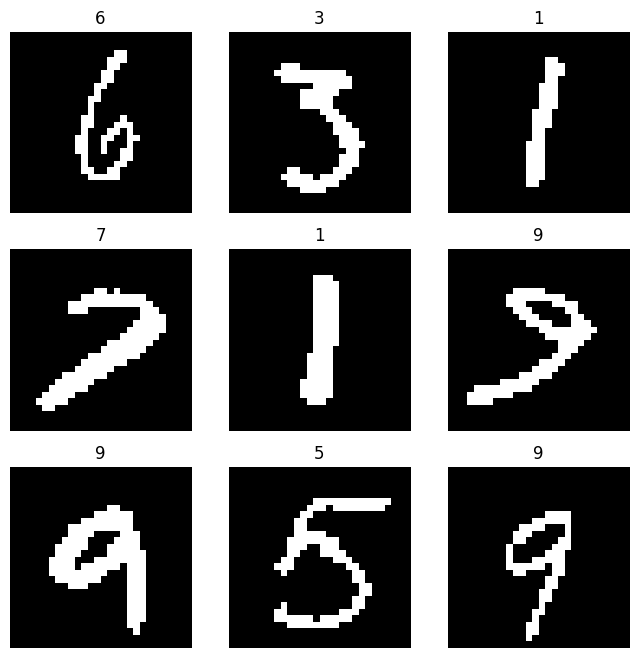

In [4]:
# show some randomly picked numbers
label_map = {k: str(k) for k in range(10)}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sidx = torch.randint(len(trainData), size=(1,)).item()
    img, label = trainData[sidx]
    figure.add_subplot(rows, cols, i)
    plt.title(label_map[torch.argmax(label, dim=0).item()])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap='gray')
plt.show()

###### Hardware Specs

In [5]:
cudaavailable = torch.cuda.is_available()
mpsavailable = torch.backends.mps.is_available()
curr_device = torch.cuda.current_device()

device = torch.device("cuda" if cudaavailable else "mps" if mpsavailable else "cpu")
device_count = torch.cuda.device_count() 
device_name =  torch.cuda.get_device_name(0)

print(f'Cuda available: {cudaavailable}')
print(f'Current device: {curr_device}')
print(f'Device: {device}')
print(f'Device count: {device_count}')
print(f'Device name: {device_name}')

Cuda available: True
Current device: 0
Device: cuda
Device count: 1
Device name: NVIDIA GeForce GTX 970


##### MNIST

###### Restricted Boltzmann Machine

In [6]:
# build the encoder and decoder networks
hid_dim = 64
model = restrictedBoltzmannMachine((1, 28, 28), hid_dim)

In [7]:
learning_rate = 1e-4
batch_size = 128
epochs = 50

trainLoader = DataLoader(trainImageData, batch_size=batch_size, shuffle=True)
validLoader = DataLoader(testImageData, batch_size=batch_size, shuffle=True)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [8]:
model.trainLoop(trainLoader, optimizer, epochs, 
                reportIters=100, scheduler=None,
                checkpointPath='../checkpoints/mnist_rbm/',
                checkPointName='rbm_64',
                validDataLoader=validLoader)

Epoch 1
-------------------------------
reconLoss: 181.411713 totalLoss: -9.050797 positiveLoss: -44.484169 negativeLoss: -35.433372[12800/60000]
reconLoss: 160.529099 totalLoss: -38.150505 positiveLoss: -57.207321 negativeLoss: -19.056818[25600/60000]
reconLoss: 142.857925 totalLoss: -57.041595 positiveLoss: -75.672325 negativeLoss: -18.630730[38400/60000]
reconLoss: 130.420074 totalLoss: -69.279099 positiveLoss: -87.410568 negativeLoss: -18.131472[51200/60000]
Validation Error: -75.206139
Epoch 2
-------------------------------
reconLoss: 119.509178 totalLoss: -77.852493 positiveLoss: -93.403053 negativeLoss: -15.550564[12800/60000]
reconLoss: 115.137833 totalLoss: -82.029266 positiveLoss: -95.954239 negativeLoss: -13.924971[25600/60000]
reconLoss: 112.280487 totalLoss: -84.428123 positiveLoss: -97.277420 negativeLoss: -12.849296[38400/60000]
reconLoss: 110.647362 totalLoss: -86.784592 positiveLoss: -96.992691 negativeLoss: -10.208097[51200/60000]
Validation Error: -90.617714
Epoch 3

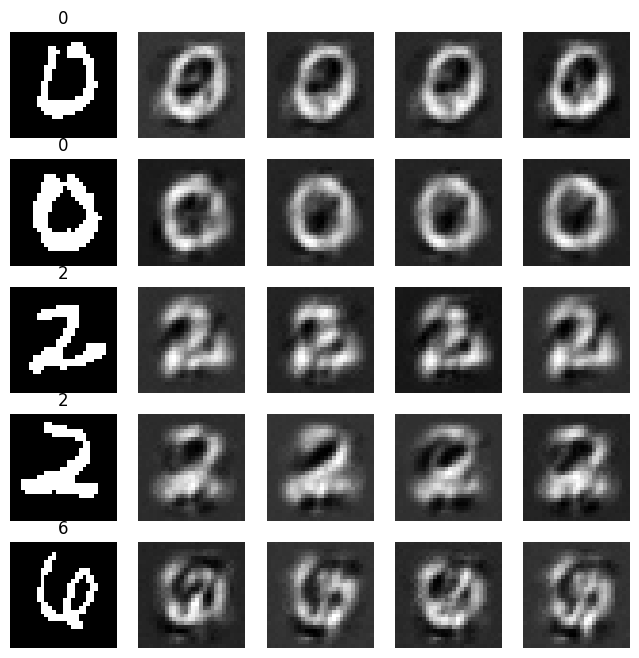

In [51]:
nimages, nsamples = 5, 4
figure = plt.figure(figsize=(8, 8))
model.eval()

for i in range(nimages):
    sidx = torch.randint(len(testData), size=(1,)).item()
    img, label = testData[sidx]
    
    n = i * (nsamples + 1) + 1
    figure.add_subplot(nimages, nsamples + 1, n)
    plt.title(label_map[torch.argmax(label, dim=0).item()])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap='gray')
    
    for j in range(1, nsamples + 1):
        n = i * (nsamples + 1) + j + 1
        smpl = model.reconstruct(img.unsqueeze(0))
        figure.add_subplot(nimages, nsamples + 1, n)
        plt.axis("off")
        plt.imshow(smpl.detach().squeeze(), cmap='gray')
        # plt.imshow(torch.where(smpl.squeeze() > 0.5, 1.0, 0.0), cmap='gray')  # thresholds the output
        
plt.show()

###### Variational Autoencoder

In [54]:
# build the encoder and decoder networks
hid_dim = 2

encoder = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2, padding=1),
                        nn.ReLU(),
                        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1),
                        nn.ReLU(),
                        nn.Flatten(), # reshape([3136]), # 
                        nn.Linear(3136, hid_dim + hid_dim))

decoder = nn.Sequential(nn.Linear(2, 32 * 7 * 7),
                        nn.ReLU(),
                        reshape([32, 7, 7]),
                        nn.ConvTranspose2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1),
                        nn.ReLU(),
                        nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=1, output_padding=1),
                        nn.ReLU(),
                        nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=3, stride=1, padding=1),
                        nn.Sigmoid())

model = variationalAutoencoder(encoder, decoder).to(device)

In [56]:
learning_rate = 1e-3
batch_size = 128
epochs = 25

trainLoader = DataLoader(trainImageData, batch_size=batch_size, shuffle=True)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [57]:
model.trainLoop(trainLoader, optimizer, epochs, 
                reportIters=100, scheduler=None,
                checkpointPath='../checkpoints/mnist_vae/',
                checkPointName='vae_2',
                validDataLoader=validLoader)

Epoch 1
-------------------------------
totalLoss: 199.541199 reconLoss: 192.855911 klLoss: 6.685291[12800/60000]
totalLoss: 180.096817 reconLoss: 173.683319 klLoss: 6.413501[25600/60000]
totalLoss: 175.941101 reconLoss: 169.447250 klLoss: 6.493858[38400/60000]
totalLoss: 176.669083 reconLoss: 170.316650 klLoss: 6.352435[51200/60000]
Validation Error: 171.076416
Epoch 2
-------------------------------
totalLoss: 175.577942 reconLoss: 169.220856 klLoss: 6.357091[12800/60000]
totalLoss: 169.207153 reconLoss: 162.608292 klLoss: 6.598865[25600/60000]
totalLoss: 158.735352 reconLoss: 151.614273 klLoss: 7.121074[38400/60000]
totalLoss: 168.065262 reconLoss: 161.336700 klLoss: 6.728568[51200/60000]
Validation Error: 163.660599
Epoch 3
-------------------------------
totalLoss: 164.603821 reconLoss: 157.894409 klLoss: 6.709413[12800/60000]
totalLoss: 166.763611 reconLoss: 160.095215 klLoss: 6.668389[25600/60000]
totalLoss: 152.256805 reconLoss: 145.378815 klLoss: 6.877983[38400/60000]
totalLos

In [58]:
# inference
def plot_latent_space(n=30, figsize=15, scale=1.0):
    # display a n*n 2D manifold of digits
    digit_size = 28
    
    figure = np.zeros((digit_size * n, digit_size * n))
    
    # linearly spaced coordinates corresponding in the 2D latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float32).to(device)
            x_decoded = model.decoder(z_sample)[0].cpu().detach()
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size : (i + 1) * digit_size,
                   j * digit_size : (j + 1) * digit_size] = digit

    plt.figure(figsize=(figsize, figsize))
    
    # set axis ticks corresponding to latent values
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    plt.xticks(pixel_range, np.round(grid_x, 1))
    plt.yticks(pixel_range, np.round(grid_y, 1))

    # axis labels
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

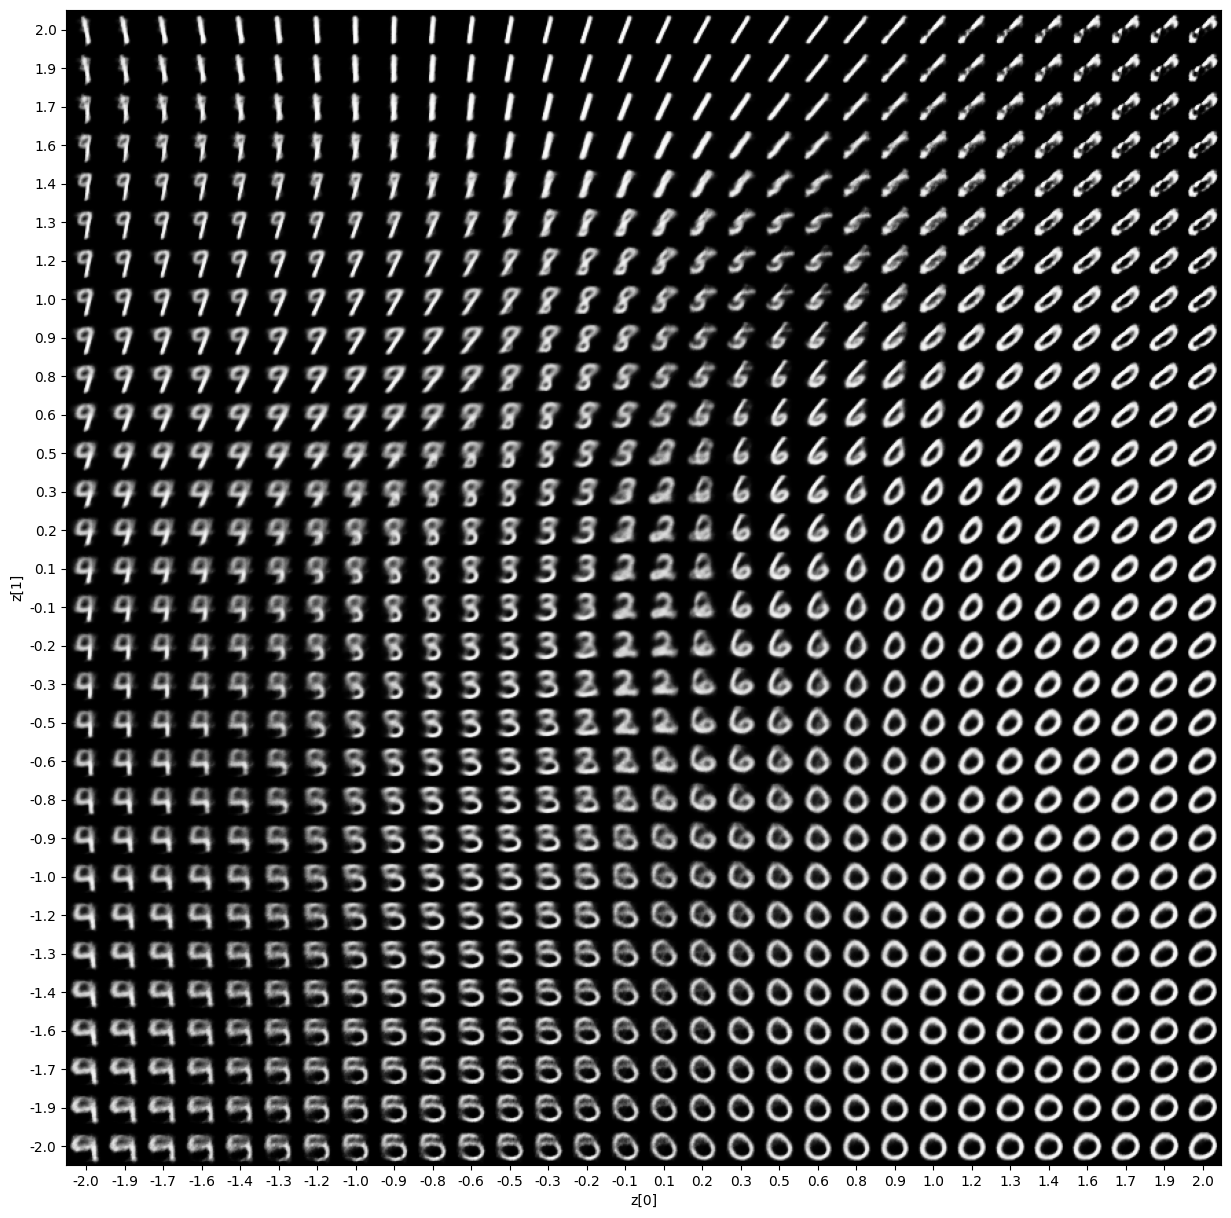

In [59]:
plot_latent_space(scale=2.0, n=30)

###### β-VAE

In [60]:
# build the encoder and decoder networks
hid_dim = 2
beta = 2.0

encoder = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2, padding=1),
                        nn.ReLU(),
                        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1),
                        nn.ReLU(),
                        nn.Flatten(), # reshape([3136]), # 
                        nn.Linear(3136, hid_dim + hid_dim))

decoder = nn.Sequential(nn.Linear(2, 32 * 7 * 7),
                        nn.ReLU(),
                        reshape([32, 7, 7]),
                        nn.ConvTranspose2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1),
                        nn.ReLU(),
                        nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=1, output_padding=1),
                        nn.ReLU(),
                        nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=3, stride=1, padding=1),
                        nn.Sigmoid())

model = variationalAutoencoder(encoder, decoder, beta).to(device)

In [61]:
learning_rate = 1e-3
batch_size = 128
epochs = 25

trainLoader = DataLoader(trainImageData, batch_size=batch_size, shuffle=True)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [62]:
model.trainLoop(trainLoader, optimizer, epochs, 
                reportIters=100, scheduler=None,
                checkpointPath='../checkpoints/mnist_bvae/',
                checkPointName='bvae_2_2',
                validDataLoader=validLoader)

Epoch 1
-------------------------------
totalLoss: 199.963440 reconLoss: 191.977448 klLoss: 3.992995[12800/60000]
totalLoss: 190.383896 reconLoss: 180.445068 klLoss: 4.969416[25600/60000]
totalLoss: 170.045731 reconLoss: 160.098450 klLoss: 4.973641[38400/60000]
totalLoss: 173.236237 reconLoss: 162.881668 klLoss: 5.177283[51200/60000]
Validation Error: 173.861755
Epoch 2
-------------------------------
totalLoss: 180.274872 reconLoss: 170.569778 klLoss: 4.852544[12800/60000]
totalLoss: 172.848633 reconLoss: 162.445068 klLoss: 5.201784[25600/60000]
totalLoss: 169.437546 reconLoss: 158.732025 klLoss: 5.352760[38400/60000]
totalLoss: 160.735672 reconLoss: 149.866211 klLoss: 5.434731[51200/60000]
Validation Error: 168.382431
Epoch 3
-------------------------------
totalLoss: 165.925949 reconLoss: 155.007187 klLoss: 5.459384[12800/60000]
totalLoss: 160.313187 reconLoss: 149.299011 klLoss: 5.507091[25600/60000]
totalLoss: 161.833237 reconLoss: 150.787399 klLoss: 5.522917[38400/60000]
totalLos

In [63]:
# inference
def plot_latent_space(n=30, figsize=15, scale=1.0):
    # display a n*n 2D manifold of digits
    digit_size = 28
    
    figure = np.zeros((digit_size * n, digit_size * n))
    
    # linearly spaced coordinates corresponding in the 2D latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float32).to(device)
            x_decoded = model.decoder(z_sample)[0].cpu().detach()
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size : (i + 1) * digit_size,
                   j * digit_size : (j + 1) * digit_size] = digit

    plt.figure(figsize=(figsize, figsize))
    
    # set axis ticks corresponding to latent values
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    plt.xticks(pixel_range, np.round(grid_x, 1))
    plt.yticks(pixel_range, np.round(grid_y, 1))

    # axis labels
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

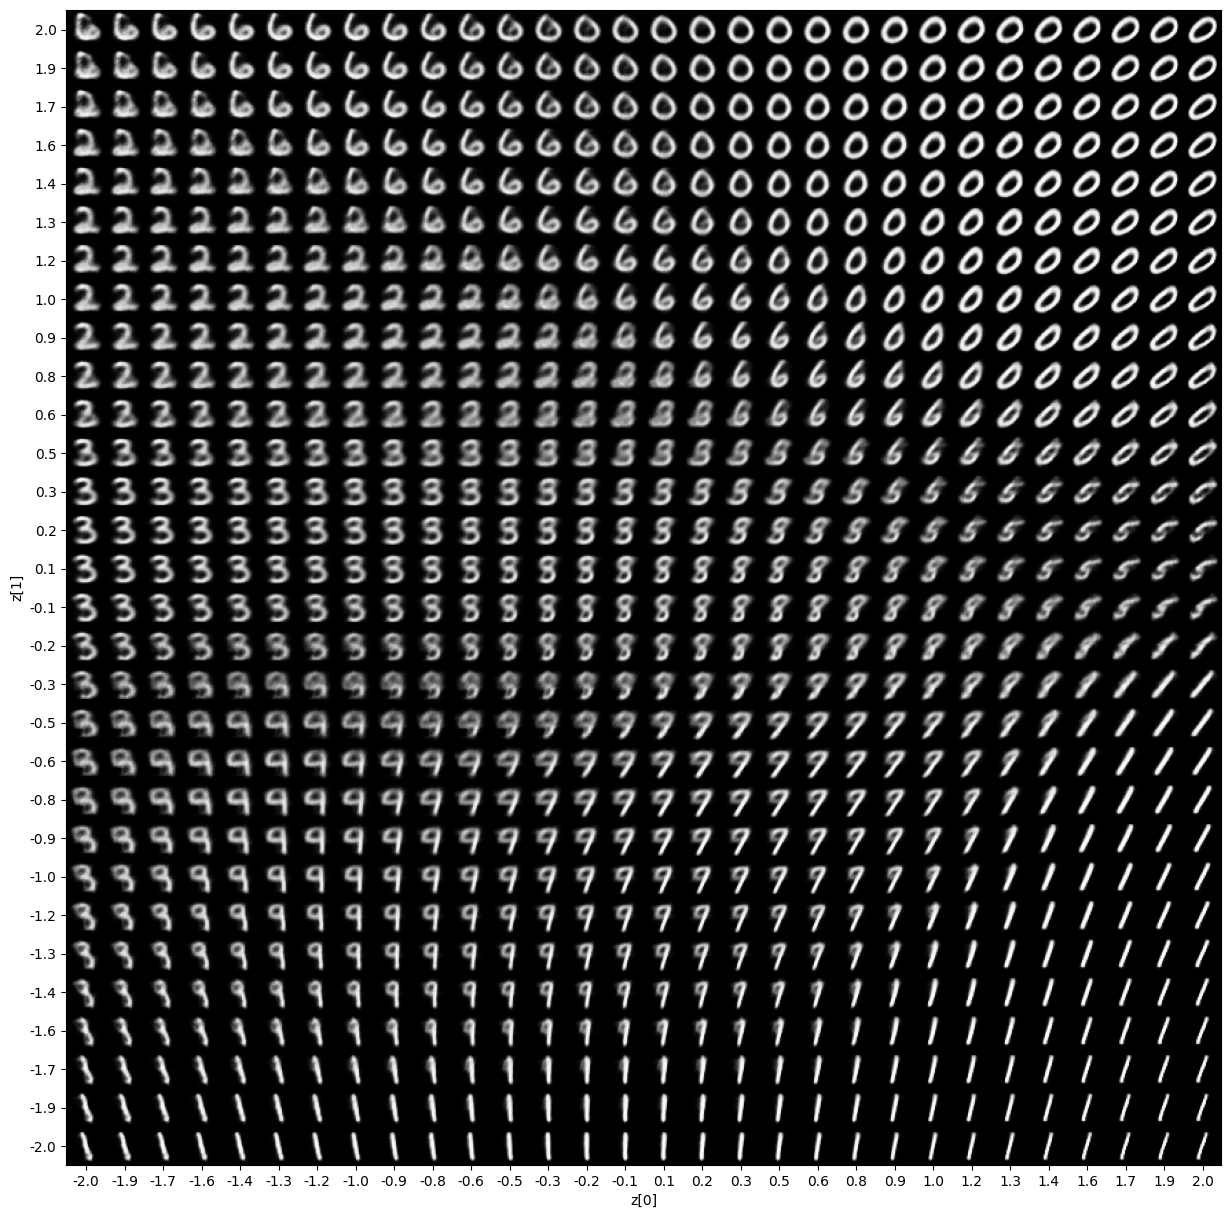

In [64]:
plot_latent_space(scale=2.0, n=30)